In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Paths

In [2]:
data_root = '../../data/'

# Dataset

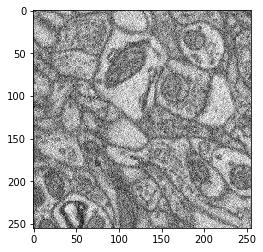

In [3]:
# Let's look at some data
img = plt.imread('../../data/2016-05-26_st015_000303_000_000_000_n_00_crop_000.tif')
plt.imshow(img, cmap='gray');

In [4]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [5]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = plt.imread(os.path.join(self.data_root, self.data_fnames[idx]))
        sample = self._normalize(img)
        return sample
    
    def _normalize(self, img):
        sample = (np.asarray(img).astype(np.int32)-self.norm_params['mean'])/self.norm_params['std']
        return sample

## Instantiate dataset subclass

In [6]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)

## Test dataset subclass

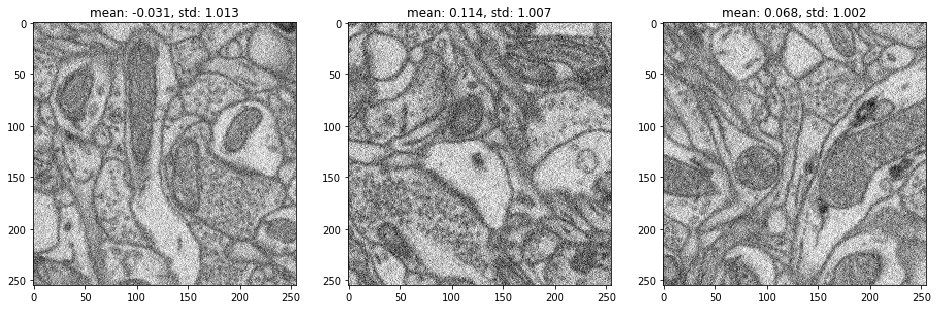

In [7]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    img = sbem_dataset[i]
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

# Model

## Define Model

In [8]:
class ConvAE2D(nn.Module):
    def __init__(self):
        super(ConvAE2D, self).__init__()
        self.encoding_layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.encoding_layer2 = nn.Sequential(
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.decoding_layer1 = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.decoding_layer2 = nn.Sequential(
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        
    def forward(self, x):
        x = self.encoding_layer1(x)
        x = self.encoding_layer2(x)
        x = self.decoding_layer1(x)
        x = self.decoding_layer2(x)
        return x

## Instantiate Model

In [9]:
net = ConvAE2D()

## Loss and optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train Model

In [12]:
trainloader = DataLoader(sbem_dataset, batch_size=1, shuffle=True, num_workers=0)
n_epoch = 2
for epoch in range(n_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 1, 3, 3], but got 3-dimensional input of size [1, 255, 255] instead